In [229]:
##### import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [234]:
##### definition
def build_model1(input_shape, kernel_size, pool_size, activation, n_classes):
    model = Sequential()
    
    model.add(Conv2D(filters=64, kernel_size=kernel_size, input_shape=input_shape))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(rate=0.1))

    model.add(Conv2D(filters=64, kernel_size=kernel_size))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(rate=0.1))

    model.add(Flatten())
    model.add(Dense(16, activation=activation))
    model.add(Dense(n_classes, activation='softmax'))
    return model

def build_model2(input_shape, kernel_size, pool_size, activation, n_classes):
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=kernel_size, input_shape=input_shape))
    model.add(BatchNormalization(momentum=0.9, epsilon=1e-06))
    model.add(Activation(activation))
    model.add(Conv2D(filters=32, kernel_size=kernel_size))
    model.add(BatchNormalization(momentum=0.9, epsilon=1e-06))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Conv2D(filters=64, kernel_size=kernel_size))
    model.add(BatchNormalization(momentum=0.9, epsilon=1e-06))
    model.add(Activation(activation))
    model.add(Conv2D(filters=64, kernel_size=kernel_size))
    model.add(BatchNormalization(momentum=0.9, epsilon=1e-06))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Conv2D(filters=64, kernel_size=kernel_size))
    model.add(BatchNormalization(momentum=0.9, epsilon=1e-06))
    model.add(Activation(activation))
    model.add(Conv2D(filters=64, kernel_size=kernel_size))
    model.add(BatchNormalization(momentum=0.9, epsilon=1e-06))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Conv2D(filters=64, kernel_size=kernel_size))
    model.add(BatchNormalization(momentum=0.9, epsilon=1e-06))
    model.add(Activation(activation))
    model.add(Conv2D(filters=64, kernel_size=kernel_size))
    model.add(BatchNormalization(momentum=0.9, epsilon=1e-06))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(rate=0.2))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization(momentum=0.9, epsilon=1e-06))
    model.add(Activation(activation))
    model.add(Dropout(rate=0.2))
    model.add(Dense(32))
    model.add(BatchNormalization(momentum=0.9, epsilon=1e-06))
    model.add(Activation(activation))
    model.add(Dense(n_classes))
    model.add(BatchNormalization(momentum=0.9, epsilon=1e-06))
    model.add(Activation(activation='softmax'))
    return model

In [235]:
##### create a data generator
datagen_test = ImageDataGenerator(rescale=1./255)

datagen_train = ImageDataGenerator(rescale=1./255,
                             rotation_range=0.5,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             shear_range=0.05,
                             zoom_range=0.05,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [236]:
##### load and iterate training, validation, test dataset
train_gen = datagen_train.flow_from_directory('../images/train/', 
                                        target_size=(256, 256), 
                                        class_mode='categorical', 
                                        batch_size=16, 
                                        save_to_dir=None,
                                        color_mode = 'rgb', 
                                        shuffle=True)

val_gen = datagen_test.flow_from_directory('../images/validation/', 
                                      target_size=(256, 256), 
                                      class_mode='categorical', 
                                      batch_size=16, 
                                      save_to_dir=None, 
                                      color_mode = 'rgb', 
                                      shuffle=True)

test_gen = datagen_test.flow_from_directory('../images/test/', 
                                       target_size=(256, 256), 
                                       class_mode='categorical', 
                                       batch_size=16, 
                                       save_to_dir=None,
                                       color_mode = 'rgb', 
                                       shuffle=True)

Found 10832 images belonging to 3 classes.
Found 1547 images belonging to 3 classes.
Found 3095 images belonging to 3 classes.


In [238]:
input_shape = (256,256,3)
kernel_size = (3, 3)
pool_size = (2, 2)
activation='relu'
n_classes = 3
n_epoch = 30

learning_rate = [0.00005]

##### build model
model = build_model2(input_shape, kernel_size, pool_size, activation, n_classes)
model.summary()

callback = [EarlyStopping(monitor='val_loss', patience=25, mode='min', min_delta=0.0001),
            ModelCheckpoint(filepath='../models/model01.h5', monitor='val_accuracy', mode='max', save_best_only=True)]
            #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1, cooldown=1)

train_result=[]
test_result=[]
for rate in learning_rate:
    
    print("learning_rate:",rate)
    ##### compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(learning_rate=rate, nesterov=True, momentum=0.9, decay=1e-6),
                  metrics=['accuracy', 'Precision', keras.metrics.Recall()])
    
    ##### fit model
    history = model.fit_generator(train_gen, ### model.fit()
                        epochs=n_epoch, 
                        validation_data=val_gen, callbacks=callback) 
                        ### steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
                        ### validation_steps = TotalvalidationSamples / ValidationBatchSize
    
    ##### evaluate model
    score_train = model.evaluate_generator(train_gen, steps=200) ### model.evaluate()
    score_test = model.evaluate_generator(test_gen, steps=200)
    
    train_result.append(score_train)
    test_result.append(score_test)
    
    print("train model score:", score_train)
    print("test model score:", score_test)

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_364 (Conv2D)          (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_207 (Bat (None, 254, 254, 32)      128       
_________________________________________________________________
activation_222 (Activation)  (None, 254, 254, 32)      0         
_________________________________________________________________
conv2d_365 (Conv2D)          (None, 252, 252, 32)      9248      
_________________________________________________________________
batch_normalization_208 (Bat (None, 252, 252, 32)      128       
_________________________________________________________________
activation_223 (Activation)  (None, 252, 252, 32)      0         
_________________________________________________________________
max_pooling2d_179 (MaxPoolin (None, 126, 126, 32)    

In [242]:
##### load model
model.save('../models/model0.h5')
model = models.load_model('../models/model0.h5')
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_364 (Conv2D)          (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_207 (Bat (None, 254, 254, 32)      128       
_________________________________________________________________
activation_222 (Activation)  (None, 254, 254, 32)      0         
_________________________________________________________________
conv2d_365 (Conv2D)          (None, 252, 252, 32)      9248      
_________________________________________________________________
batch_normalization_208 (Bat (None, 252, 252, 32)      128       
_________________________________________________________________
activation_223 (Activation)  (None, 252, 252, 32)      0         
_________________________________________________________________
max_pooling2d_179 (MaxPoolin (None, 126, 126, 32)    

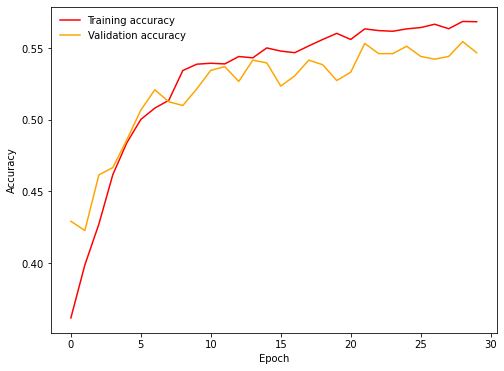

In [243]:
##### plot accuracy
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['accuracy'], color='red')
ax.plot(history.history['val_accuracy'], color='orange')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'], frameon=False)
plt.show()
#fig.savefig('accuracy5.png')

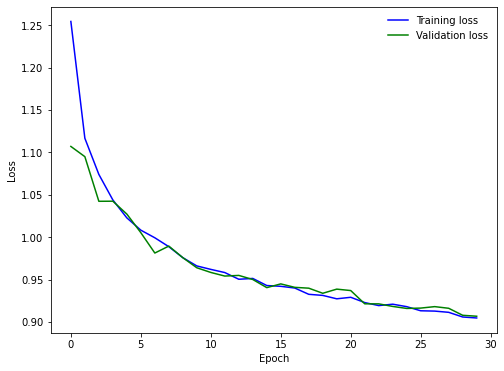

In [244]:
##### plot loss
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], color='blue')
ax.plot(history.history['val_loss'], color='green')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.legend(['Training loss', 'Validation loss'], frameon=False)
plt.show()
#fig.savefig('loss5.png')